# Prototyping Visualizations for the Web with Vega and Julia

In [1]:
import Pkg
Pkg.activate(pwd())

using HTTP
using Gumbo
using AbstractTrees
using Dates
using DataFrames

using VegaLite
using DataVoyager

using TextAnalysis
using JSON


## Fetch and clean the data from JuliaCon's Talk web site

In [2]:
function getURLBody(url::String)
    resp = HTTP.get(url)
    doc = parsehtml(String(resp.body));
    return doc.root[2];
end

getURLBody (generic function with 1 method)

In [3]:
# fetch the talk data
# WARNING: this may take a few minutes
url = "https://pretalx.com/juliacon2019/talk/";
body = getURLBody(url);
talks = Gumbo.children(body[2][2][1])

# initialize rowtable to hold the data
data = NamedTuple{(:index, :title, :url, :speaker, :start_datetime, :end_datetime, :duration, :location, :text), 
                    Tuple{Int, String, String, String, DateTime, DateTime, Int, String, String}}[]

i = 1
base_talk_url = "https://pretalx.com"

# iterate through each talk to parse, clean, and fetch more data
for talk in talks
    # skip any non-talks
    typeof(talk) !== HTMLElement{:section} && continue
    
    # parse out the talk url
    a = talk[1][1]
    link = getattr(a, "href")
    
    # scrape the talk page for data
    talk_url = base_talk_url * link
    s = strip.(split(talk[1][2][1].text, "·", keepempty=false))
    s[end] == "" && pop!(s)
    speakers = join(s, ", ")
    talk_body = getURLBody(talk_url)
    article = talk_body[2][2][1][1]
    
    # get the title, logistics, and text fields
    title = string(strip(article[1][1][1].text, ['\n', ' ', '\t']))
    d, t, l = split(strip(article[1][2][1].text, ['\n', ' ', '\t']), ", ")
    date = Date(d)
    start_time, end_time = Time.(split(t, "–"))
    start_datetime = DateTime(date, start_time)
    end_datetime = DateTime(date, end_time)
    duration = Minute(end_time - start_time).value
    location = string(l)
    
    location == "Other" && continue # skip non-talks
    title == "Hackathon" && continue # skip the hackathon
    location[1:2] == "PH" && continue # skip workshops
    
    # get and concatenate the abstract and description
    text = ""
    for elem in PreOrderDFS(article[2][1]) 
        # will fail on HTMLText, where text actually is
        try
            tag(elem) == :section && getattr(elem, "class") in ["resources", "answers"] && break
        catch
            p = elem.text
            # remove html tags used for styling
            text *= replace(p, r"<.*>" => " ") * " "   
        end
    end
    
    # save to array
    push!(data, NamedTuple{
                (:index, :title, :url, :speaker, :start_datetime, :end_datetime, :duration, :location, :text), 
                    Tuple{Int, String, String, String, DateTime, DateTime, Int, String, String}}(
                    (i, title, talk_url, speakers, start_datetime, end_datetime, duration, location, text)
                    )
        )
        
    i += 1
end

## The Data

Some logistics, some text, some things that are nice to reference back to

In [23]:
d = data |> DataFrame |> describe

,variable,mean,min
,Symbol,Union…,Any
1,index,66.0,1
2,title,,A New Breed of Vehicle Simulation
3,url,,https://pretalx.com/juliacon2019/talk/37VY3Q/
4,speaker,,Aaron Christianson
5,start_datetime,,2019-07-23T08:30:00
6,end_datetime,,2019-07-23T08:40:00
7,duration,24.084,5
8,location,,BOF
9,text,,"""This block will compile away,"" the comments say. But will it? In this talk we'll see some scenarios where controlling compile-time vs runtime execution is crucial for performance, and we'll discuss some ideas that might make this control easier in Julia. Julia's ability to compile away complex logic is remarkable. Especially in recent releases, Const-propagation is a thing to behold! But we've found it can be hard to reason about why some operations are compiled away (or why they aren't), and even harder to control that behavior. What's more, that behavior can change as your code evolves, or Julia is updated, and it's difficult to test. In Julia, the distinction between compile-time and runtime is deliberately muddy: compilation itself happens during runtime ; a function may be compiled once, many times or never—it might even be compiled more times than it runs. Still, there are cases where we expect a function to be compiled once, early on, and then need it to run extremely quickly, many times, in a tight loop, where controlling the ability to move work from runtime to compile-time is critical. This talk will explore a few such motivating cases we've seen at RelationalAI , including in pieces of the FixedPointDecimals.jl library. We'll examine the options currently available in Julia for controlling compile-time execution, and their pros and cons, including some lessons-learned about the pain we've experienced with @generated . We'll study the approach modern C++ is taking to this problem, with its constexpr annotation. And we'll propose a few ideas for how we might add features to Julia that could increase our control over this fierce compiler."


# Data Voyager might be magic

In [7]:
# run data voyager
data |> Voyager();

### Before

Copied directly from Voyager, but before iterating and improving

WARN column encoding should be discrete (ordinal / nominal / binned).
WARN column encoding should be discrete (ordinal / nominal / binned).


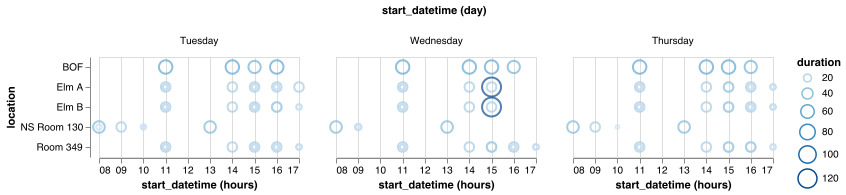

In [5]:
vl"""{
  "data": {
    "name": "source"
  },
  "mark": "point",
  "encoding": {
    "x": {
      "timeUnit": "hours",
      "field": "start_datetime",
      "type": "temporal",
      "scale": {}
    },
    "y": {
      "field": "location",
      "type": "nominal"
    },
    "column": {
      "timeUnit": "day",
      "field": "start_datetime",
      "type": "temporal"
    },
    "size": {
      "field": "duration",
      "type": "quantitative"
    },
    "color": {
      "field": "duration",
      "type": "quantitative"
    }
  },
  "config": {
    "overlay": {
      "line": true
    },
    "scale": {
      "useUnaggregatedDomain": true
    }
  }
}"""(data)

## After

Fancy up the formatting, change from circles to rectangles, link to the url on click

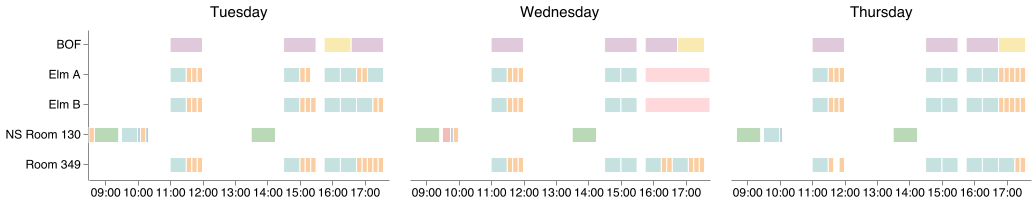

In [6]:
spec = vl"""{
  "height": 150,
  "width": 300,
  "data": {
    "vaues": []
  },
  "selection": {
    "paintbrush": {
      "type": "multi",
      "on": "mouseover", "empty": "none"
    }
  },
  "mark": {
      "type": "rect", 
      "filled": true,
      "opacity": 1.0,
      "strokeWidth": 1,
      "stroke": "white"
  },
  "encoding": {
    "column": {
      "field": "start_datetime",
      "title": null,
      "type": "ordinal",
      "timeUnit": "day"
    },
    "x": {
      "field": "start_datetime",
      "title": null,
      "type": "temporal",
      "timeUnit": "hoursminutes",
      "axis": {
        "orient": "bottom"
      }
    },
    "x2": {
    "field": "end_datetime",
      "title": null,
      "type": "temporal",
      "timeUnit": "hoursminutes"
    },
    "y": {
      "field": "location",
      "title": null,
      "type": "nominal",
      "scale": { "type": "band", "paddingInner": 0.5 }
    },
    "href": { "field": "url" },
    "color": {
      "field": "duration",
      "type": "nominal",
      "legend": null
    },
    "fillOpacity": {
      "condition": {
        "selection": "paintbrush", "value": 1.0
      },
      "value": 0.4
    },
    "tooltip": [
      {"field": "title", "type": "nominal"},
      {"field": "speaker", "title": "Speaker", "type": "nominal"},
      {"field": "location", "title": "Location", "type": "nominal"},
      {"field": "start_datetime", "title": "Date & Time", "type": "temporal", "timeUnit": "yearmonthdatehoursminutes"},
      {"field": "duration", "title": "Duration (min)", "type": "quantitative"}
    ]
  },
  "config": {
    "overlay": {
      "line": true
    },
    "scale": {
      "useUnaggregatedDomain": true
    },
    "axis": {
      "gridOpacity": 0,
      "labelFontSize": 12,
      "titleFontSize": 12
    },
    "header": {
      "labelFontSize": 15
    },
    "view": {
      "strokeOpacity": 0
    }
  }
}"""(data)

# That's a nice calendar, but what are these talks about?

Let's do some natural language processing (NLP) to find out

In [28]:
# Let's do some NLP

# create the corpus
sds = map(x -> StringDocument(x.text), data)
corpus = Corpus(sds)

# clean up the data
remove_case!(corpus)
prepare!(corpus, strip_articles| strip_non_letters| strip_stopwords| strip_pronouns)
remove_words!(corpus, ["julia", "jl", "talk", "using"]) # too common :(

# set up the lexicon
lexicon(corpus)
update_lexicon!(corpus)

# light stemming - combine simple 's' plurals with their singular (e.g. models == model)
pairs = Pair{String, String}[]
for (k, v) in lexicon(corpus)
    if k[end] == 's' && haskey(lexicon(corpus), k[1:end-1])
        push!(pairs, k => k[1:end-1])
    end
end

# replace plurals and update the lexicon
for doc in corpus
    for pair in pairs
        doc.text = replace(doc.text, pair)
    end
end
update_lexicon!(corpus)

# set up inverse index
inverse_index(corpus)
update_inverse_index!(corpus)

In [29]:
# bi-grams - find common two word phrases

bg = NGramDocument[]

for d in corpus
    push!(bg, NGramDocument(ngrams(d, 2), 1, d.metadata))
end

bg_corpus = Corpus(bg)

# set up inverse index
inverse_index(bg_corpus)
update_inverse_index!(bg_corpus)

# set up the lexicon
lexicon(bg_corpus)
update_lexicon!(bg_corpus)

In [30]:
# tri-grams - find common three word phrases

tg = NGramDocument[]

for d in corpus
    push!(tg, NGramDocument(ngrams(d, 3), 1, d.metadata))
end

tg_corpus = Corpus(tg)

# set up inverse index
inverse_index(tg_corpus)
update_inverse_index!(tg_corpus)

# set up the lexicon
lexicon(tg_corpus)
update_lexicon!(tg_corpus)

In [24]:
# get overall count of a term in the n+1 gram's dictionary
function subgram_count(term, np1grams)
    count = 0
    for (k, v) in np1grams
        if occursin(term, k)
            count += v
        end
    end
    
    return count
end

subgram_count (generic function with 1 method)

In [25]:
# prune and combine an n gram with it's n+1 gram given a cut off count
function remove_ngrams(ngrams, np1grams, cut_off)
    new_ngrams = Dict{String, Int}()
    for (k, v) in ngrams
        new_count = v - subgram_count(k, np1grams)
        if new_count > cut_off
            new_ngrams[k] = new_count
        end
    end
    
    return merge(new_ngrams, np1grams)
end

remove_ngrams (generic function with 1 method)

In [32]:
function remove_ngrams(ngrams, cut_off)
    new_ngrams = Dict{String, Int}()
    for (k, v) in ngrams
        if v > cut_off
            new_ngrams[k] = v
        end
    end
    
    return new_ngrams
end

remove_ngrams (generic function with 2 methods)

In [34]:
# combine ngrams and find most commone words and phrases
tg_cut_off = 2
bg_cut_off = 4
ug_cut_off = 15

new_tg = remove_ngrams(lexicon(tg_corpus), tg_cut_off)
new_bg = remove_ngrams(lexicon(bg_corpus), new_tg, bg_cut_off)
new_ug = remove_ngrams(lexicon(corpus), new_bg, ug_cut_off)

# turn the n-grams into tabular data for plotting
word_data = NamedTuple{(:text, :count, :talks), Tuple{String, Int, Array}}[]
for (word, count) in new_ug
    inds = []
    word_len = length(split(word))
    if word_len == 3
        inds = inverse_index(tg_corpus)[word]
    elseif word_len == 2
        inds = inverse_index(bg_corpus)[word]
    else
        inds = inverse_index(corpus)[word]
    end
    push!(word_data, NamedTuple{(:text, :count, :talks), Tuple{String, Int, Array}}((word, count * word_len^2, inds)))
end

word_data |> DataFrame |> describe

,variable,mean,min
,Symbol,Union…,Any
1,text,,aircraft
2,count,31.3247,16
3,talks,,"[1, 3, 6, 11, 16, 17, 20, 21, 24, 25, 27, 33, 43, 44, 47, 51, 54, 56, 60, 61, 63, 67, 69, 72, 73, 74, 78, 79, 86, 87, 100, 103, 105, 106, 107]"


# Plotting the topics

## Before

Found a nice example word cloud at https://vega.github.io/vega/examples/word-cloud/

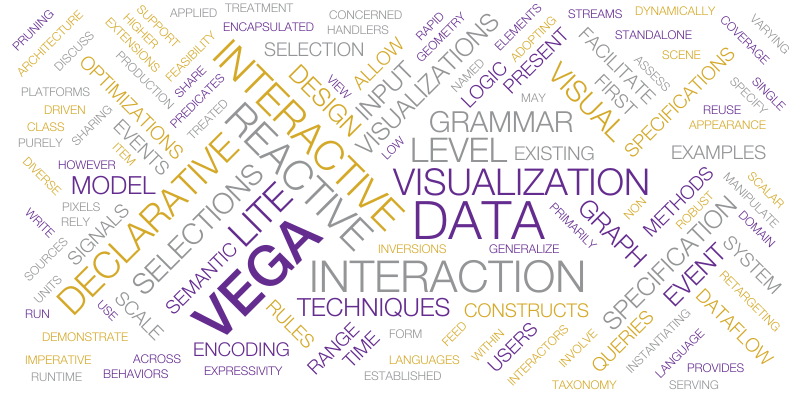

In [11]:
vg"""{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "width": 800,
  "height": 400,
  "padding": 0,

  "data": [
    {
      "name": "table",
      "values": [
        "Declarative visualization grammars can accelerate development, facilitate retargeting across platforms, and allow language-level optimizations. However, existing declarative visualization languages are primarily concerned with visual encoding, and rely on imperative event handlers for interactive behaviors. In response, we introduce a model of declarative interaction design for data visualizations. Adopting methods from reactive programming, we model low-level events as composable data streams from which we form higher-level semantic signals. Signals feed predicates and scale inversions, which allow us to generalize interactive selections at the level of item geometry (pixels) into interactive queries over the data domain. Production rules then use these queries to manipulate the visualization’s appearance. To facilitate reuse and sharing, these constructs can be encapsulated as named interactors: standalone, purely declarative specifications of interaction techniques. We assess our model’s feasibility and expressivity by instantiating it with extensions to the Vega visualization grammar. Through a diverse range of examples, we demonstrate coverage over an established taxonomy of visualization interaction techniques.",
        "We present Reactive Vega, a system architecture that provides the first robust and comprehensive treatment of declarative visual and interaction design for data visualization. Starting from a single declarative specification, Reactive Vega constructs a dataflow graph in which input data, scene graph elements, and interaction events are all treated as first-class streaming data sources. To support expressive interactive visualizations that may involve time-varying scalar, relational, or hierarchical data, Reactive Vega’s dataflow graph can dynamically re-write itself at runtime by extending or pruning branches in a data-driven fashion. We discuss both compile- and run-time optimizations applied within Reactive Vega, and share the results of benchmark studies that indicate superior interactive performance to both D3 and the original, non-reactive Vega system.",
        "We present Vega-Lite, a high-level grammar that enables rapid specification of interactive data visualizations. Vega-Lite combines a traditional grammar of graphics, providing visual encoding rules and a composition algebra for layered and multi-view displays, with a novel grammar of interaction. Users specify interactive semantics by composing selections. In Vega-Lite, a selection is an abstraction that defines input event processing, points of interest, and a predicate function for inclusion testing. Selections parameterize visual encodings by serving as input data, defining scale extents, or by driving conditional logic. The Vega-Lite compiler automatically synthesizes requisite data flow and event handling logic, which users can override for further customization. In contrast to existing reactive specifications, Vega-Lite selections decompose an interaction design into concise, enumerable semantic units. We evaluate Vega-Lite through a range of examples, demonstrating succinct specification of both customized interaction methods and common techniques such as panning, zooming, and linked selection."
      ],
      "transform": [
        {
          "type": "countpattern",
          "field": "data",
          "case": "upper",
          "pattern": "[\\w']{3,}",
          "stopwords": "(i|me|my|myself|we|us|our|ours|ourselves|you|your|yours|yourself|yourselves|he|him|his|himself|she|her|hers|herself|it|its|itself|they|them|their|theirs|themselves|what|which|who|whom|whose|this|that|these|those|am|is|are|was|were|be|been|being|have|has|had|having|do|does|did|doing|will|would|should|can|could|ought|i'm|you're|he's|she's|it's|we're|they're|i've|you've|we've|they've|i'd|you'd|he'd|she'd|we'd|they'd|i'll|you'll|he'll|she'll|we'll|they'll|isn't|aren't|wasn't|weren't|hasn't|haven't|hadn't|doesn't|don't|didn't|won't|wouldn't|shan't|shouldn't|can't|cannot|couldn't|mustn't|let's|that's|who's|what's|here's|there's|when's|where's|why's|how's|a|an|the|and|but|if|or|because|as|until|while|of|at|by|for|with|about|against|between|into|through|during|before|after|above|below|to|from|up|upon|down|in|out|on|off|over|under|again|further|then|once|here|there|when|where|why|how|all|any|both|each|few|more|most|other|some|such|no|nor|not|only|own|same|so|than|too|very|say|says|said|shall)"
        },
        {
          "type": "formula", "as": "angle",
          "expr": "[-45, 0, 45][~~(random() * 3)]"
        },
        {
          "type": "formula", "as": "weight",
          "expr": "if(datum.text=='VEGA', 600, 300)"
        }
      ]
    }
  ],

  "scales": [
    {
      "name": "color",
      "type": "ordinal",
      "domain": {"data": "table", "field": "text"},
      "range": ["#d5a928", "#652c90", "#939597"]
    }
  ],

  "marks": [
    {
      "type": "text",
      "from": {"data": "table"},
      "encode": {
        "enter": {
          "text": {"field": "text"},
          "align": {"value": "center"},
          "baseline": {"value": "alphabetic"},
          "fill": {"scale": "color", "field": "text"}
        },
        "update": {
          "fillOpacity": {"value": 1}
        },
        "hover": {
          "fillOpacity": {"value": 0.5}
        }
      },
      "transform": [
        {
          "type": "wordcloud",
          "size": [800, 400],
          "text": {"field": "text"},
          "rotate": {"field": "datum.angle"},
          "font": "Helvetica Neue, Arial",
          "fontSize": {"field": "datum.count"},
          "fontWeight": {"field": "datum.weight"},
          "fontSizeRange": [12, 56],
          "padding": 2
        }
      ]
    }
  ]
}"""


## After

Insert JuliaCon Data, blues are nice, angles are not, add a placehoder signal to manipulate in the web app

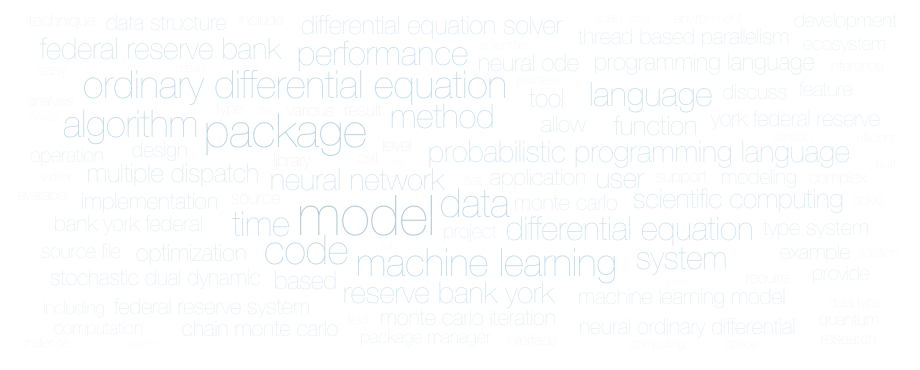

In [42]:
word_data_json = JSON.json(word_data);

word_cloud_spec = """{
  "width": 900,
  "height": 350,
  "padding": 10,
  "signals": [
    {"name": "hoverID", "value": 0}
  ],

  "data": [
    {
      "name": "table",
      "values": $(word_data_json)
    }
  ],

  "scales": [
    {
      "name": "color",
      "type": "log",
      "domain": {"data": "table", "field": "count"},
      "range": {"scheme": "purpleblue"}
    }
  ],

  "marks": [
    {
      "type": "text",
      "from": {"data": "table"},
      "encode": {
        "enter": {
          "text": {"field": "text"},
          "align": {"value": "center"},
          "baseline": {"value": "alphabetic"},
          "fill": {"scale": "color", "field": "count"}
        },
        "update": {
          "fillOpacity": [
            {"test": "indexof(datum.talks, hoverID) > 0", "value": 1.0},
            {"value": 0.3}
          ]
        },
        "hover": {
          "fillOpacity": {"value": 1.0}
        }
      },
      "transform": [
        {
          "type": "wordcloud",
          "size": [{"signal": "width"}, {"signal": "height"}],
          "text": {"field": "text"},
          "font": "Helvetica Neue, Arial",
          "fontSize": {"field": "datum.count"},
          "fontSizeRange": [12, 56],
          "padding": 2
        }
      ]
    }
  ]
}"""

VegaLite.VGSpec(JSON.parse(word_cloud_spec))


## And that's all!

To publish the visualizations to the web, click the "..." button in the top right of the visualization and select "View Compiled Vega" if using Vega Lite or "View Source" if using Vega. This will open a new tab with a full vega specification including data, which can then be used for publishing on the web.